In [ ]:
# ..... cell-cycle scoring ..... #

In [2]:
library(Seurat)
library(ggplot2)

In [3]:
# list of stages and samples
stages = rep(c('stage9', 'stage13', 'stage16'), each = 3)
samples = paste0('sample', rep(1:3, 3))

In [4]:
# load cell-cycle genes list
load('~/septation/cc.genes.rda')

# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

In [5]:
# load data
id = 7
file0 = paste0(stages[id], '_', samples[id], '_raw_data.rds')
sce = readRDS(file0)
sce

An object of class Seurat 
22732 features across 10290 samples within 1 assay 
Active assay: RNA (22732 features, 0 variable features)
 1 layer present: counts

In [6]:
# filter high MT cells
sce <- sce[,which(sce$mitoRatio<0.05)]

# remove low-expressed genes, cells with very low or very high UMI
sce <- sce[,which(sce$nFeature_RNA>150 & sce$nCount_RNA>150 & sce$nCount_RNA<12000)]
dim(sce)

[1] 22732  9762

In [7]:
# normalize data so that samples with many lowly-expressed genes can still return cell-cycle scores
# try min.cells = 1 if cell-cycle scoring still throws up error
sce <- NormalizeData(sce)

# Perform cell cycle scoring
sce <- CellCycleScoring(sce, g2m.features = g2m.genes, s.features = s.genes, set.ident = TRUE)
sce@meta.data[1,]

Normalizing layer: counts

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: UBE2C, FAM64A, CCNB2, HJURP, HN1, CENPA, not searching for symbol synonyms”


orig.ident nCount_RNA nFeature_RNA
stage16_sample1_AAACCCACAGCTGTCG-1 stage16    1309       715         
                                   mitoRatio  log10GenesPerUMI stage   sample 
stage16_sample1_AAACCCACAGCTGTCG-1 0.01375095 0.9157399        stage16 sample1
                                   S.Score   G2M.Score   Phase old.ident
stage16_sample1_AAACCCACAGCTGTCG-1 0.0113321 -0.01275822 S     stage16

In [8]:
# run pca on data
sce <- FindVariableFeatures(sce, selection.method = "vst")
sce <- ScaleData(sce, features = rownames(sce), verbose = FALSE)
sce <- RunPCA(sce, features = VariableFeatures(sce), verbose =  FALSE)

Finding variable features for layer counts



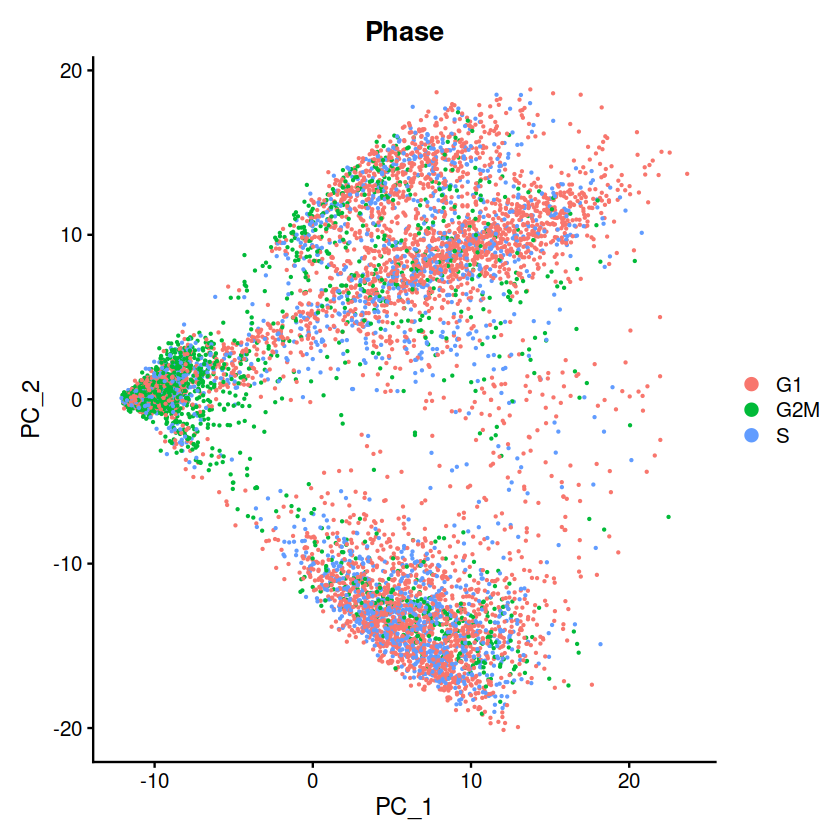

In [9]:
# Visualize the PCA, grouping by cell cycle phase
# png(paste0(stages[id], '_', samples[id], '_pca_cellcycle.png'), width = 8, height = 8, res = 300, units = 'in')
DimPlot(sce, reduction = "pca", group.by = "Phase")
# dev.off()

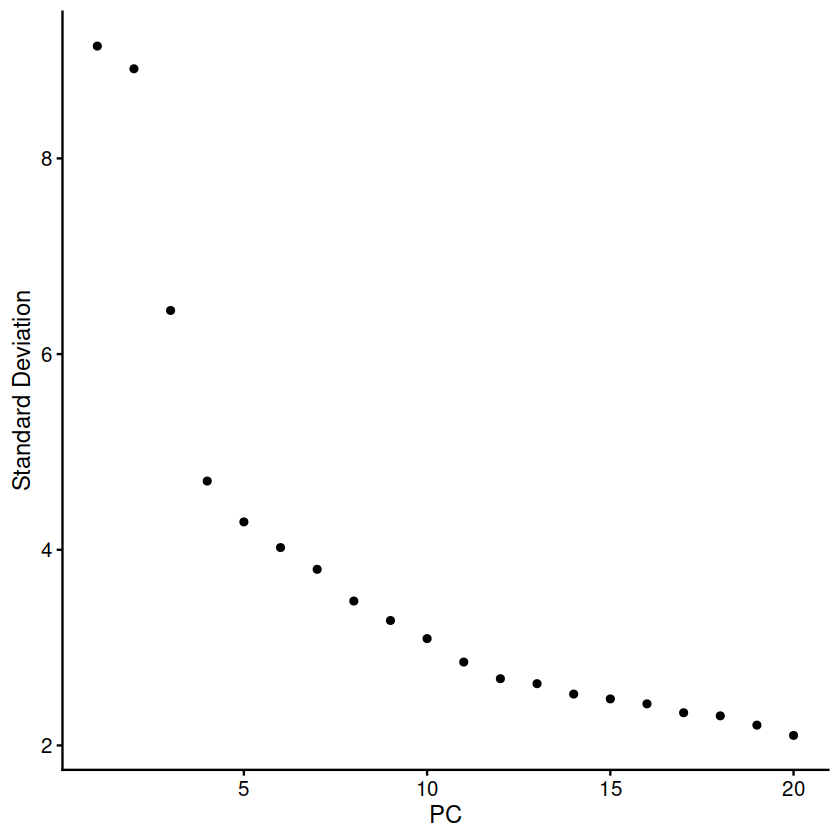

In [10]:
# elbow plot for num of PCs to choose
ElbowPlot(object = sce)

In [11]:
# cluster the data
sce <- FindNeighbors(sce, dims = 1:20, k = 30)
sce <- FindClusters(object = sce, resolution = 0.5, verbose = FALSE)

# run umap
sce <- RunUMAP(object = sce, dims = 1:20, verbose = FALSE)

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


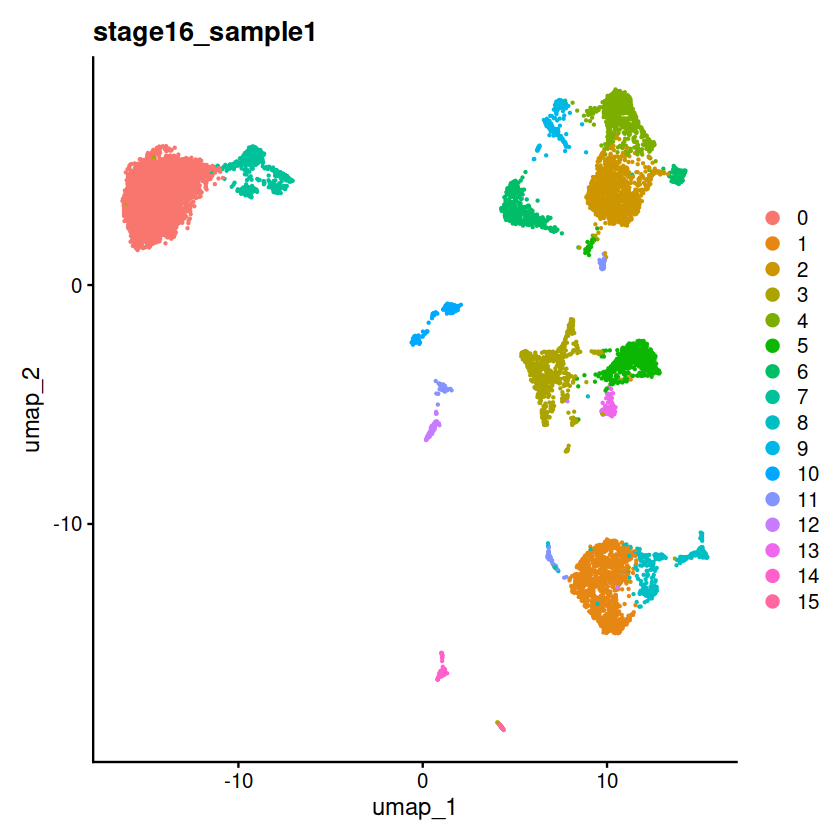

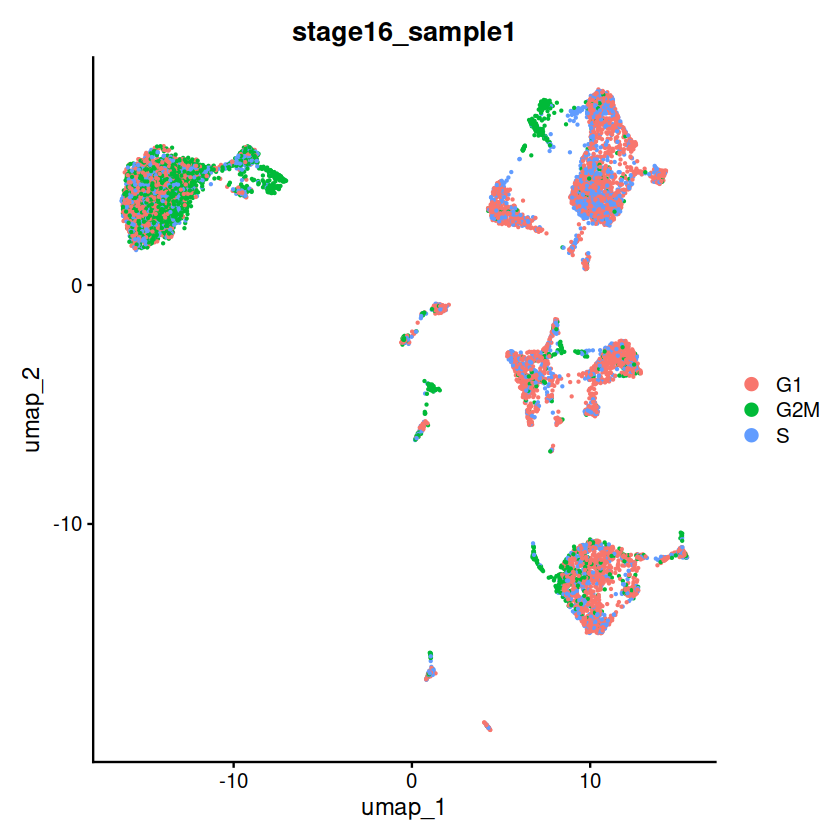

In [12]:
# plot umap
# png(paste0(stages[id], '_', samples[id], '_umap_clusters.png'), width = 8, height = 8, res = 300, units = 'in')
DimPlot(sce) + ggtitle(paste0(stages[id], '_', samples[id]))
# dev.off()

# png(paste0(stages[id], '_', samples[id], '_umap_cellcycle.png'), width = 8, height = 8, res = 300, units = 'in')
DimPlot(sce, reduction = 'umap', group.by = 'Phase') + ggtitle(paste0(stages[id], '_', samples[id]))
# dev.off()

In [13]:
# save file
saveRDS(sce, file = paste0(stages[id], '_', samples[id], '_data.rds'))